# Understanding Annotation Consolidation: A SageMaker Ground Truth Demonstration for Image Classification

## Introduction
This sample notebook demonstrates how Ground Truth annotation consolidation works and shows the performance improvement achieved by the built-in annotation consolidation algorithm for image classification over alternate approaches.

We start with the output of a labeling job where 5 workers annotated 302 images of birds from [Google Open Images Dataset](https://storage.googleapis.com/openimages/web/index.html).

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from collections import defaultdict
import itertools
import json
import random
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn.metrics import confusion_matrix
import boto3
import glob
from scipy import stats
import pandas as pd 
from io import BytesIO
from PIL import Image
import pickle

# Set up the files you will need for the analysis.
subprocess.run(['tar', '-xvf', 'ic_data.tar.gz'])

CompletedProcess(args=['tar', '-xvf', 'ic_data.tar.gz'], returncode=0)

## Analyze Ground Truth labeling job results

Whether you use the output of the job we already ran or a new job, we are now ready to analyze the results, all contained in the output manifest. If you ran your own job, you can find the location of the output manifest under AWS Console > SageMaker > Labeling Jobs > [name of your job]. For our pre-completed job, we will obtain it programmatically in the cell below.

### Postprocess the output manifest

First, download the output manifest and postprocess it to form:

* `img_uris` -- array containing the S3 URIs of all the images that Ground Truth annotated.
* `true_labels` -- dictionary storing the true label categories for all the images that Ground Truth annotated. 

In [2]:
def find_true_label(src_ref, src_to_label):
    uid = src_ref.replace('s3://birdstop-ic-us-west-2/birds-open-images-subset/all_data/', '').replace('.jpg', '')
    return src_to_label[uid]

In [3]:
with open('ic_data/output.manifest', 'r') as f:
    output = [json.loads(line.strip()) for line in f.readlines()]

# Create and initialize data arrays.
img_uris = [None] * len(output)

# Find the job name the manifest corresponds to.
keys = list(output[0].keys())
metakey = [key for key in keys if ('metadata' in key)][0]
jobname = metakey.replace('-metadata', '')

#load the true class labels 
categories = ['Duck', 'Sparrow', 'Woodpecker', 'Owl', 'Parrot', 'Turkey', 'Falcon', 'Swan', 'Goose', 'Canary']
with open('ic_data/true_labels.json', 'r') as input_file:    
    true_labels_file = json.load(input_file)
    
src_to_label = {}
for true_label in true_labels_file:
    src_to_label[true_label['ImageId']] = true_label['Label']
    
true_labels = {}
# Extract the data.
for datum_id, datum in enumerate(output):
    true_labels[datum_id] = find_true_label(datum['source-ref'], src_to_label)
    img_uris[datum_id] = datum['source-ref']

### Plot histogram of true class labels

This is some preliminary data analysis to understand the class distribution. Our dataset is quite unbalanced and has categories that can be confused with each other. For example, annotators may confuse sparrows, canaries and parrots.

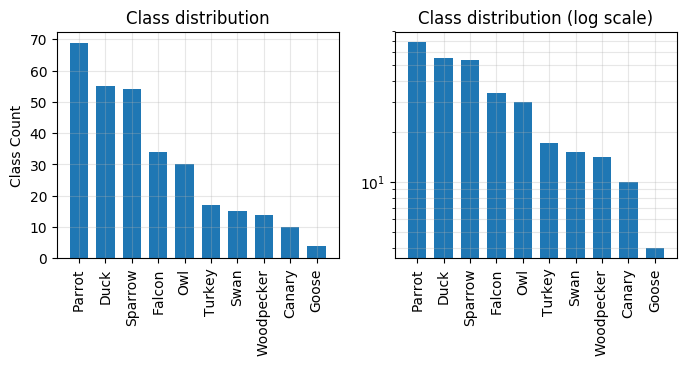

In [4]:
n_classes = len(categories)
unique_classes, class_counts = np.unique(list(true_labels.values()), return_counts=True)
sorted_class_count_idx = np.argsort(class_counts)[::-1]
sorted_unique_classes = unique_classes[sorted_class_count_idx]
sorted_class_counts = class_counts[sorted_class_count_idx]

plt.figure(figsize=(8, 3), facecolor='white', dpi=100)
plt.subplot(1, 2, 1)
plt.title('Class distribution')
plt.bar(range(n_classes), sorted_class_counts, width=0.7)
plt.xticks(range(n_classes), sorted_unique_classes, rotation='vertical')
plt.ylabel('Class Count')
plt.grid(which='both', alpha=0.3);

plt.subplot(1, 2, 2)
plt.title('Class distribution (log scale)')
plt.bar(range(n_classes), sorted_class_counts, width=0.7, log=True)
plt.xticks(range(n_classes), sorted_unique_classes, rotation='vertical')
plt.grid(which='both', alpha=0.3);

### Comparison of Consolidation Methods
We now compare the performance of our consolidation algorithm, Modified Dawid-Skene (MDS), with the standard baselines of Single Worker (SW) and Majority Voting (MV). For MDS and MV, we can see how the performance changes as the number of annotators increases.

In [5]:
class DataLayer(object):
    
    """
    This is a simple substitute for the actual data layer class, for use in local testing.
    It stores and retrieves pickles from a dictionary in memory.
    """

    def __init__(self):
        self.worker_params = defaultdict(dict)
        self.label_params = defaultdict(dict)

    def put_label_information_s3(self, label_data, dataset_object_id, labeling_job_arn):
        self.label_params[labeling_job_arn][dataset_object_id] = pickle.dumps(label_data)

    def get_label_information_s3(self, dataset_object_id, labeling_job_arn):
        label_data = self.label_params.get(labeling_job_arn, {}).get(dataset_object_id, None)
        if label_data:
            label_data = pickle.loads(label_data)
        return label_data

    def put_worker_information_s3(self, worker_data, worker_id, labeling_job_arn):
        self.worker_params[labeling_job_arn][worker_id] = pickle.dumps(worker_data)

    def get_worker_information_s3(self, worker_id, labeling_job_arn):
        worker_data = self.worker_params.get(labeling_job_arn, {}).get(worker_id, None)
        if worker_data:
            worker_data = pickle.loads(worker_data)
        return worker_data

class MulticlassDawidSkeneEM(object):
    """
    Implements the method described in A. P. Dawid and A. M. Skene, 1979, Maximum Likelihood Estimation of
    Observer Error-Rates Using the EM Algorithm, Journal of the Royal Statistical Society
    Series C (Applied Statistics), Vol. 28, No. 1, pp. 20-28
    https://www.jstor.org/stable/2346806
    """

    def __init__(self, labeling_job_arn, output_config=None, role_arn = None, kms_key_id = None, identifier="Testing"):
        self.labeling_job_arn = labeling_job_arn
        self.dataset_object_ids = set()
        self.worker_ids = set()
        self.l_ij = defaultdict(dict)  # A dict of dicts to store the annotations in Lij format
        self.p_prior = None  # Item priors will be an np.array len n_classes, storing the class marginal distribution
        self.max_epochs = 20
        self.min_relative_diff = 1E-8
        self.identifier = identifier
        self.data_layer = DataLayer()

    def update(self, annotation_payload, label_categories, label_attribute_name, is_text=False):
        """
        Update the worker and item parameters, based on a new batch of data
        :param annotation_payload: The payload of annotations received, which is a list of items, where each item dict
        contains a dataset_object_id, and list of annotations. Each annotation is a dict with a worker_id and
        information on the annotation content provided by that worker.
        :param label_categories: The list of possible categories for the multiclass classification
        :param label_attribute_name: The named assigned to this collection of labels
        :param is_text: Denotes that input and output are in text (not image) classification format
        :return: The updated item parameters
        """
        all_worker_prior = 0.7
        p, c_mtrx = self.get_or_initialize_parameters(annotation_payload, label_categories, all_worker_prior)
        log_likelihood = None
        for epoch in range(self.max_epochs):
            p, p_non_normalized = self.expectation_step(self.l_ij, p, c_mtrx, self.n_classes)
            c_mtrx, worker_priors = self.maximization_step(self.l_ij, p, self.n_classes,
                                                           self.worker_ids, all_worker_prior)
            log_likelihood, relative_diff = self.calc_log_likelihood(
                self.l_ij, p_non_normalized, log_likelihood
            )
            if relative_diff is not None and relative_diff < self.min_relative_diff:
                self.put_parameters(p, c_mtrx)
                responses = self.format_responses(p, label_categories, label_attribute_name, is_text)
                return responses

            all_worker_prior = sum([worker_priors[j] for j in worker_priors]) / len(worker_priors)

        self.put_parameters(p, c_mtrx)
        responses = self.format_responses(p, label_categories, label_attribute_name, is_text)
        return responses

    def get_or_initialize_parameters(self, annotation_payload, label_categories, all_worker_prior):
        """
        Sets the dataset object_ids and worker_ids, gets the item and worker params if they exist, or initializes
        them if they do not.
        :param annotation_payload: The payload of annotations received, which is a list of items, where each item dict
        contains a dataset_object_id, and list of annotations. Each annotation is a dict with a worker_id and
        information on the annotation content provided by that worker.
        :param label_categories: The list of possible categories for the multiclass classification
        :param all_worker_prior: The assumed prior accuracy rate of an average worker
        :return: None
        """

        self.label_categories = label_categories
        self.n_classes = len(label_categories)

        # Store the dataset object_ids and worker_ids, and store the annotation dataset in Lij form
        for item in annotation_payload:
            i = item['datasetObjectId']
            self.dataset_object_ids.add(i)
            for annotation in item['annotations']:
                j = annotation['workerId']
                self.worker_ids.add(j)
                annotation_content = annotation['annotationData']['content']
                self.l_ij[i][j] = self.label_categories.index(annotation_content)

        # Get or initialize the item parameters
        # Item params are a dict of np label-class arrays, keyed by dataset_object_id (i)
        p = {}
        for i in self.dataset_object_ids:
            # item_params = self.data_layer.get_label_information_s3(i, self.labeling_job_arn)
            item_params = self.initialize_item_parameters(n_classes=self.n_classes)
            p[i] = item_params

        # Get or initialize the worker parameters
        # Worker params are a dict of np confusion matrices, keyed by worker_id (j)
        c_mtrx = {}
        for j in self.worker_ids:
            # worker_params = self.data_layer.get_worker_information_s3(j, self.labeling_job_arn)
            worker_params = self.initialize_worker_params(n_classes=self.n_classes, a=all_worker_prior)
            c_mtrx[j] = worker_params

        return p, c_mtrx

    def put_parameters(self,  p, c_mtrx):
        """
        Write the item and worker parameters back to the data layer
        :return: None
        """
        # Write the item parameters back to the data layer
        for i in self.dataset_object_ids:
            pickled_label_data = pickle.dumps(p[i])
            self.data_layer.put_label_information_s3(pickled_label_data, self.labeling_job_arn,  i)

        # Write the worker parameters back to the data layer
        for j in self.worker_ids:
            pickled_worker_data = pickle.dumps(c_mtrx[j])
            self.data_layer.put_worker_information_s3(pickled_worker_data, self.labeling_job_arn, j)

    @staticmethod
    def initialize_item_parameters(n_classes):
        """
        Initializes item parameters to an even probability distribution across all classes
        :param n_classes: The number of classes
        :return: item_parameters
        """
        return np.ones(n_classes) / n_classes

    @staticmethod
    def initialize_worker_params(n_classes, a=0.7):
        """
        Initializes worker parameters to an a confusion matrix with a default accuracy down the diagonal
        :param n_classes: The number of classes
        :param a: The assumed accuracy of a typical worker, for initializing confusion matrices
        :return: worker_params
        """
        worker_params = np.ones((n_classes, n_classes)) * ((1 - a) / (n_classes - 1))
        np.fill_diagonal(worker_params, a)
        return worker_params

    @staticmethod
    def expectation_step(l_ij, p, c_mtrx, n_classes):
        """
        The update of the true class probabilities, following equations 2.3 and 2.4 in Dawid-Skene (1979)
        :param l_ij: The annotated data, in Lij format
        :param p: The current estimate of the true class parameters (dict keyed on dataset_object_id)
        :param c_mtrx: The worker confusion matrices (dict keyed on worker_id)
        :param n_classes: The number of classes
        :return: the updated item params (p), and a non-normalized version of them to use in estimating
        the log-likelihood of the data
        """
        # Set our prior value of p to be the marginal class distribution across all items
        p_prior = np.zeros(n_classes)
        for i in p:
            p_prior += p[i]
        p_prior /= p_prior.sum()

        for i in l_ij:
            # Initialize the item params to the prior value
            p[i] = p_prior.copy()
            for j in l_ij[i]:
                annotated_class = l_ij[i][j]
                for true_class in range(n_classes):
                    error_rate = c_mtrx[j][true_class, annotated_class]
                    # Update the prior with likelihoods from the confusion matrix
                    p[i][true_class] *= error_rate

        p_non_normalized = p.copy()
        # Normalize the item parameters
        for i in p:
            if p[i].sum() > 0:
                p[i] /= float(p[i].sum())
        return p, p_non_normalized

    def maximization_step(self, l_ij, p, n_classes, worker_ids, all_worker_prior):
        """
        Update of the worker confusion matrices, following equation 2.5 of Dawid-Skene (1979)
        :param l_ij: The annotated data, in Lij format
        :param p: The current estimate of the true class parameters
        :param n_classes: The number of classes
        :param worker_ids: the set of worker_ids
        :param all_worker_prior: The prior accuracy of an average worker
        :return: The updated worker confusion matrices, c_mtrx
        """
        # Calculate the updated confusion matrices, based on the new item parameters
        all_worker_prior_mtrx = self.initialize_worker_params(n_classes, a=all_worker_prior)

        c_mtrx = {}
        worker_accuracies = {}
        for j in worker_ids:
            c_mtrx[j] = np.zeros((n_classes, n_classes))
        for i in l_ij:
            for j in l_ij[i]:
                annotated_class = l_ij[i][j]
                for true_class in range(n_classes):
                    c_mtrx[j][true_class, annotated_class] += p[i][true_class]

        for j in worker_ids:
            num_annotations = c_mtrx[j].sum()
            worker_accuracies[j] = c_mtrx[j].diagonal().sum() / num_annotations
            worker_prior_mtrx = self.initialize_worker_params(n_classes, a=worker_accuracies[j])
            c_mtrx[j] += (worker_prior_mtrx * num_annotations + all_worker_prior_mtrx * num_annotations / 2)

            # Perform dirichlet update to get new confusion matrices
            for true_class in range(n_classes):
                if c_mtrx[j][true_class].sum() > 0:
                    c_mtrx[j][true_class] /= float(c_mtrx[j][true_class].sum())

        return c_mtrx, worker_accuracies

    @staticmethod
    def calc_log_likelihood(l_ij, p_non_normalized, prev_log_likelihood=None):
        """
        Calculate the log-likelihood of the data, so that when it stops improving, we can stop iterating
        :param l_ij: The annotated data, in Lij format
        :param p_non_normalized: The non-normalized item parameters
        :param prev_log_likelihood: The log-likelihood from the previous epoch
        :return: the log-likelihood of the data, and the relative difference from the previous epoch's log-likelihood
        """
        log_likelihood = 0.0
        relative_diff = None
        for i in l_ij:
            posterior_i = p_non_normalized[i]
            likelihood_i = posterior_i.sum()
            log_likelihood += np.log(likelihood_i)

        if prev_log_likelihood:
            diff = log_likelihood - prev_log_likelihood
            relative_diff = diff / prev_log_likelihood

        return log_likelihood, relative_diff

    def format_responses(self, params, label_categories, label_attribute_name, is_text):
        responses = []
        for dataset_object_id in params:
            label_estimate = params[dataset_object_id]
            confidence_score = round(max(label_estimate), 2)
            label, index = self.retrieve_annotation(label_estimate, label_categories)
            consolidated_annotation = self.transform_to_label(label, index, label_attribute_name,
                                                              confidence_score, is_text)
            response = self.build_response(dataset_object_id, consolidated_annotation)
            responses.append(response)
        return responses

    def transform_to_label(self, estimated_label, index, label_attribute_name, confidence_score, is_text):
        if is_text:
            return self.transform_to_text_label(estimated_label, index, label_attribute_name, confidence_score)
        else:
            return self.transform_to_image_label(estimated_label, index, label_attribute_name, confidence_score)

    def transform_to_image_label(self, estimated_label, index, label_attribute_name, confidence_score):
        return {
            label_attribute_name: int(float(index)),
            label_attribute_name + "-metadata": {"class-name": estimated_label, "job-name": self.labeling_job_arn,
                                                 "confidence": confidence_score, "type": "groundtruth/text-classification",
                                                 "human-annotated": "yes", "creation-date": 'date'},
        }

    @staticmethod
    def retrieve_annotation(label_estimate, label_categories):
        elem = label_categories[np.argmax(label_estimate, axis=0)]
        index = label_categories.index(elem)
        return elem, index

    @staticmethod
    def build_response(dataset_object_id, consolidated_annotation):
        return {
            "datasetObjectId": dataset_object_id,
            "consolidatedAnnotation": {
                'content': consolidated_annotation
            }
        }

In [6]:
def most_common(labels):
    unique_classes, class_votes = np.unique(labels, return_counts=True)
    winning_num_votes = np.max(class_votes)
    winning_class = unique_classes[np.where(class_votes == winning_num_votes)]
    if len(winning_class) == 1:  # clear majority
        return winning_class[0]
    else:                        # break ties randomly
        return np.random.choice(winning_class)  

def majority_vote(dset_objects):
    final_labels = []
    for dset_object in dset_objects:
        labels = []
        for annotation in dset_object['annotations']:
            label = annotation['annotationData']['content']
            labels.append(label)
        winner = most_common(labels)
        final_labels.append({ 'datasetObjectId': dset_object['datasetObjectId'],
            'consolidatedAnnotation': {'content': {'categories-metadata': {'class-name': winner}}}})
    return final_labels

def map_labels_to_raw_annotations(dset_objects):
    raw_annotations_with_ground_truth = []
    for dset_object in dset_objects:
        true_label = true_labels[dset_object['datasetObjectId']]
        for annotation in dset_object['annotations']:
            label = annotation['annotationData']['content']
            raw_annotations_with_ground_truth.append({
                'Predicted Label': label,   # Single worker raw label
                'True Label': true_label
            })
    return raw_annotations_with_ground_truth
            
def compute_accuracy(annotated_labels):
    consolidated_annotations_with_ground_truth = []
    num_right = 0 
    for label in annotated_labels:
        dset_object_id = label['datasetObjectId']
        true_label = true_labels[dset_object_id]
        cons_label = label['consolidatedAnnotation']['content']['categories-metadata']['class-name']
        consolidated_annotations_with_ground_truth.append({
            'Predicted Label': cons_label,
            'True Label': true_label,
            'Dataset Object ID': dset_object_id
        })
        if cons_label == true_label:
            num_right = 1 + num_right
    return consolidated_annotations_with_ground_truth, num_right / len(annotated_labels)

### Simulate experiments with different numbers of annotators

In order to simulate multiple runs with different numbers of annotators, we sample 20 times from our five-annotator dataset for each annotator count. With all five annotations, there is no source of performance variation in MDS, but MV still has some variation due to the random tie breaking. Running a real experiment 20 different times with different workers would lead to performance variation in MDS as well. However, for the sake of simplicity we use the same dataset to simulate runs. 

In [7]:
# Collect all the individual worker annotations
dset_to_annotations = []
for annot_fname in glob.glob('ic_data/worker-response/**', recursive=True):
    if annot_fname.endswith('json'):
        with open(annot_fname, 'r') as f:
            annot_data = json.load(f)
        dset_id = int(annot_fname.split('/')[3])
        annotations = []
        for answer in annot_data['answers']:
            label = answer['answerContent']['crowd-image-classifier']['label'].replace(' ', '')
            worker_id = answer['workerId']
            annotations.append({'workerId': worker_id, 'annotationData':  {'content': label}})
        dset_annotations = {'datasetObjectId': dset_id,'annotations': annotations}
        dset_to_annotations.append(dset_annotations)

label_attribute_name = 'categories'

RAW_ANNOTATIONS_WITH_GROUND_TRUTH = map_labels_to_raw_annotations(dset_to_annotations)

# Find the number of annotators by looking at the annotations.
n_annotators = len(list(dset_annotations.values())[1])

dset_to_annotations_by_worker_count = {}
for i in range(1, n_annotators + 1):
    dset_to_annotations_by_worker_count[i] = dset_to_annotations
    
# Run num_iter iterations of both algorithms by sampling from the data, so we can
# plot both the mean and the error bars for the performance
num_iter = 20
ds_accuracies = defaultdict(list)
mv_accuracies = defaultdict(list)
DS_CONSOLIDATED_ANNOTATIONS_WITH_GROUND_TRUTH_ALL_RUNS = defaultdict(dict)
MV_CONSOLIDATED_ANNOTATIONS_WITH_GROUND_TRUTH_ALL_RUNS = defaultdict(dict)
for num_workers in dset_to_annotations_by_worker_count:
    for i in range(num_iter):
        annotations = []
        for dset in dset_to_annotations:
            sample = random.sample(dset['annotations'], num_workers)
            vote = {'datasetObjectId': dset['datasetObjectId'],'annotations': sample }
            annotations.append(vote)
            
        dawid_skene = MulticlassDawidSkeneEM(jobname)

        DS_CONSOLIDATED_ANNOTATIONS_WITH_GROUND_TRUTH_ALL_RUNS[num_workers][i], ds_accuracy = compute_accuracy(dawid_skene.update(annotations , 
                                                                                                         categories, label_attribute_name))
        MV_CONSOLIDATED_ANNOTATIONS_WITH_GROUND_TRUTH_ALL_RUNS[num_workers][i], mv_accuracy = compute_accuracy(majority_vote(annotations))
        ds_accuracies[num_workers].append(ds_accuracy)
        mv_accuracies[num_workers].append(mv_accuracy)

### Plot the performance as a function of the number of annotators

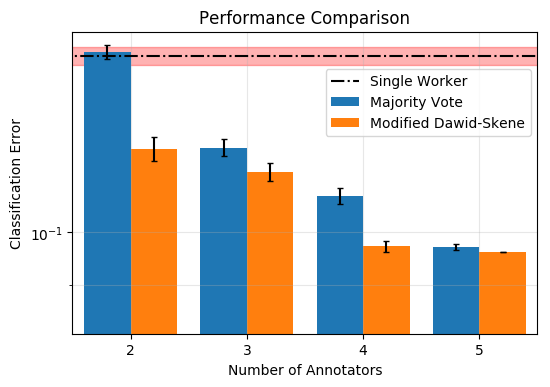

In [8]:
mv_errors = {k:1-np.array(v) for k,v in mv_accuracies.items()}
mv_err_mean = {k:np.mean(v) for k,v in mv_errors.items()}
mv_err_sem = {k:stats.sem(v) for k,v in mv_errors.items()}

ds_errors = {k:1-np.array(v) for k,v in ds_accuracies.items()}
ds_err_mean = {k:np.mean(v) for k,v in ds_errors.items()}
ds_err_sem = {k:stats.sem(v) for k,v in ds_errors.items()}

annotator_range = np.arange(1, 6)
y_mv, y_mv_sem, y_ds, y_ds_sem = [],[],[],[]
for k in annotator_range:
    y_mv.append(mv_err_mean[k])
    y_mv_sem.append(mv_err_sem[k])
    y_ds.append(ds_err_mean[k])
    y_ds_sem.append(ds_err_sem[k])

w = 0.4
fig= plt.figure(figsize=(6, 4), facecolor='white', dpi=100)
plt.bar(annotator_range[1:]-w/2, y_mv[1:], width=w, yerr=y_mv_sem[1:], log=True, capsize=2, label='Majority Vote')
plt.bar(annotator_range[1:]+w/2, y_ds[1:], width=w, yerr=y_ds_sem[1:], log=True, capsize=2, label='Modified Dawid-Skene')
sw = np.array([y_mv[0]]*6)
sw_sem = np.array([y_mv_sem[0]]*6)
plt.plot(range(1,7), sw, 'k-.', label='Single Worker')
plt.fill_between(range(1,7), sw - sw_sem, sw + sw_sem, color='r', alpha=0.3)
fig.gca().yaxis.set_minor_formatter(NullFormatter())
plt.xlim([1.5,5.5])
plt.xticks(annotator_range[1:])
plt.title('Performance Comparison')
plt.ylabel('Classification Error')
plt.xlabel('Number of Annotators')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
plt.grid(which='both', alpha=0.3);

### Find examples where MV and MDS disagree

The performance of MV and MDS can be close depending on the dataset and workforce. In the dataset we use, this is indeed the case. However, the preceding plot shows that MDS outperforms MV on average. In the following cells, we try to find a simulated run where there was at least one image that MDS got right over MV and vice versa.

In [9]:
images_ds_got_right_mv_got_wrong_list = []
images_mv_got_right_ds_got_wrong_list = []
worker_count = 5
for i in range(num_iter):
    ds_data = pd.DataFrame(data=DS_CONSOLIDATED_ANNOTATIONS_WITH_GROUND_TRUTH_ALL_RUNS[worker_count][i], columns =['True Label', 'Predicted Label', 'Dataset Object ID'])
    ds_data = ds_data.sort_values(by=['Dataset Object ID'])
    y_true_ds = ds_data['True Label']
    y_pred_ds = ds_data['Predicted Label']

    mv_data = pd.DataFrame(data=MV_CONSOLIDATED_ANNOTATIONS_WITH_GROUND_TRUTH_ALL_RUNS[worker_count][i], columns =['True Label', 'Predicted Label', 'Dataset Object ID'])
    mv_data = mv_data.sort_values(by=['Dataset Object ID'])
    y_true_mv = mv_data['True Label']
    y_pred_mv = mv_data['Predicted Label']

    ds_ids = ds_data['Dataset Object ID'].values
    images_ds_got_right = ds_ids[np.where(y_true_ds == y_pred_ds)]
    images_ds_got_wrong = ds_ids[np.where(y_true_ds != y_pred_ds)]

    mv_ids = mv_data['Dataset Object ID'].values
    images_mv_got_right = mv_ids[np.where(y_true_mv == y_pred_mv)]
    images_mv_got_wrong = mv_ids[np.where(y_true_mv != y_pred_mv)]

    images_ds_got_right_mv_got_wrong = set(images_ds_got_right) & set(images_mv_got_wrong)
    images_mv_got_right_ds_got_wrong = set(images_mv_got_right) & set(images_ds_got_wrong)
    images_mv_got_wrong_ds_got_wrong = set(images_mv_got_wrong) & set(images_ds_got_wrong)
    images_ds_got_right_mv_got_wrong_list.append(len(images_ds_got_right_mv_got_wrong))
    images_mv_got_right_ds_got_wrong_list.append(len(images_mv_got_right_ds_got_wrong))
    print('%%%%%%%%% Run number: {} %%%%%%%%%'.format(i))
    print('Number of images that Majority Voting got right: {}'.format(len(images_mv_got_right)))
    print('Number of images that Modified Dawid-Skene got right: {}'.format(len(images_ds_got_right)))
    print('Number of images that Majority Voting got wrong but Modified Dawid-Skene got right: {}'.format(len(images_ds_got_right_mv_got_wrong)))
    print('Number of images that Modified Dawid-Skene got wrong but Majority Voting got right: {}'.format(len(images_mv_got_right_ds_got_wrong)))
    print('Number of images that both Modified Dawid-Skene and Majority Voting got wrong: {}'.format(len(images_mv_got_wrong_ds_got_wrong)))

%%%%%%%%% Run number: 0 %%%%%%%%%
Number of images that Majority Voting got right: 273
Number of images that Modified Dawid-Skene got right: 273
Number of images that Majority Voting got wrong but Modified Dawid-Skene got right: 1
Number of images that Modified Dawid-Skene got wrong but Majority Voting got right: 1
Number of images that both Modified Dawid-Skene and Majority Voting got wrong: 28
%%%%%%%%% Run number: 1 %%%%%%%%%
Number of images that Majority Voting got right: 272
Number of images that Modified Dawid-Skene got right: 273
Number of images that Majority Voting got wrong but Modified Dawid-Skene got right: 1
Number of images that Modified Dawid-Skene got wrong but Majority Voting got right: 0
Number of images that both Modified Dawid-Skene and Majority Voting got wrong: 29
%%%%%%%%% Run number: 2 %%%%%%%%%
Number of images that Majority Voting got right: 272
Number of images that Modified Dawid-Skene got right: 273
Number of images that Majority Voting got wrong but Modif

In [10]:
runs_where_ds_made_corrections_to_mv = np.where(np.array(images_ds_got_right_mv_got_wrong_list) != 0)
runs_where_mv_made_corrections_to_ds = np.where(np.array(images_mv_got_right_ds_got_wrong_list) != 0)
run_where_both_made_corrections = set(runs_where_ds_made_corrections_to_mv[0]) & set(runs_where_mv_made_corrections_to_ds[0])
if len(run_where_both_made_corrections) != 0:
    chosen_run = np.random.choice(list(run_where_both_made_corrections))
elif len(runs_where_ds_made_corrections_to_mv) != 0:
    chosen_run = np.random.choice(list(runs_where_ds_made_corrections_to_mv))
elif len(runs_where_mv_made_corrections_to_ds) != 0:
    chosen_run = np.random.choice(list(runs_where_mv_made_corrections_to_ds))
else:
    chosen_run = np.random.choice(range(num_iter))

### Visualize Confusion Matrices
Another interesting way to look at performance is through confusion matrices, which show how often classes are confused with each other. For a perfect predictor, there is no misclassification, and the confusion matrix will have 1s on the diagonal and 0s everywhere else. Let's plot these for the chosen run.

In [11]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', 
                          cmap=plt.cm.Blues, xlabel='Predicted Label', ylabel='True Label'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        pass
    else:
        pass

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel(ylabel, fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.tight_layout()

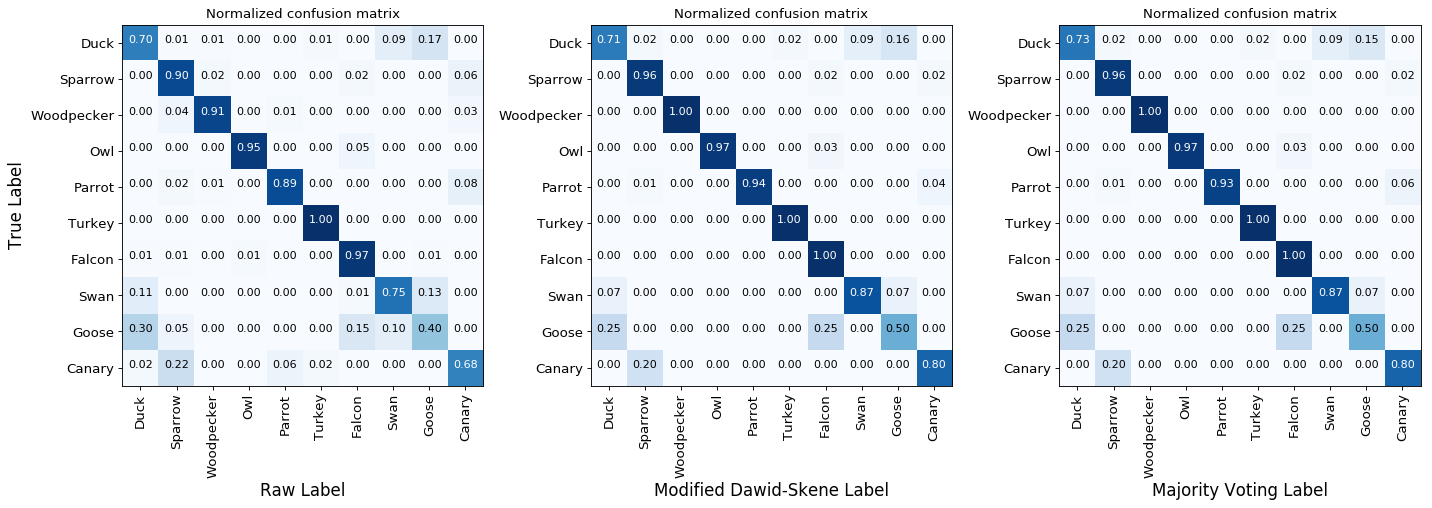

In [12]:
# Prepare the data. Compute the confusion matrices.
raw_data = pd.DataFrame(data=RAW_ANNOTATIONS_WITH_GROUND_TRUTH, columns =['True Label', 'Predicted Label'])
y_true_raw = raw_data['True Label']
y_pred_raw = raw_data['Predicted Label']
cnf_matrix_raw = confusion_matrix(y_true_raw, y_pred_raw, labels=categories)

DS_CONSOLIDATED_ANNOTATIONS_WITH_GROUND_TRUTH = DS_CONSOLIDATED_ANNOTATIONS_WITH_GROUND_TRUTH_ALL_RUNS[worker_count][chosen_run]
ds_data = pd.DataFrame(data=DS_CONSOLIDATED_ANNOTATIONS_WITH_GROUND_TRUTH, columns =['True Label', 'Predicted Label', 'Dataset Object ID'])
ds_data = ds_data.sort_values(by=['Dataset Object ID'])
y_true_ds = ds_data['True Label']
y_pred_ds = ds_data['Predicted Label']
cnf_matrix_ds = confusion_matrix(y_true_ds, y_pred_ds, labels=categories)

MV_CONSOLIDATED_ANNOTATIONS_WITH_GROUND_TRUTH = MV_CONSOLIDATED_ANNOTATIONS_WITH_GROUND_TRUTH_ALL_RUNS[worker_count][chosen_run]
mv_data = pd.DataFrame(data=MV_CONSOLIDATED_ANNOTATIONS_WITH_GROUND_TRUTH, columns =['True Label', 'Predicted Label', 'Dataset Object ID'])
mv_data = mv_data.sort_values(by=['Dataset Object ID'])
y_true_mv = mv_data['True Label']
y_pred_mv = mv_data['Predicted Label']
cnf_matrix_mv = confusion_matrix(y_true_mv, y_pred_mv, labels=categories)

# Plot the confusion matrices
plt.figure(num=None, figsize=(18, 9), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,3,1)
plot_confusion_matrix(cnf_matrix_raw, classes=categories, normalize=True,
                      xlabel='Raw Label', title='Normalized confusion matrix')
plt.subplot(1,3,2)
plot_confusion_matrix(cnf_matrix_ds, classes=categories, normalize=True,
                      ylabel='', xlabel='Modified Dawid-Skene Label', title='Normalized confusion matrix')
plt.subplot(1,3,3)
plot_confusion_matrix(cnf_matrix_mv, classes=categories, normalize=True,
                      ylabel='', xlabel='Majority Voting Label', title='Normalized confusion matrix')

### Qualitative Comparison of Modified Dawid-Skene and Majority Voting
Let’s now look at some qualitative results. We look at three sets of example images: (1) Images which Majority Voting got wrong but Dawid-Skene got right. (2) Images which Dawid-Skene got wrong but Majority Voting got right. (3) Images that both got wrong.

In [13]:
dset_id_to_annotations_dict = {}
for dset_ann in dset_to_annotations:
    dset_obj_id = dset_ann['datasetObjectId']
    annotation_list = []
    for anno_with_metadata in dset_ann['annotations']:
        annotation_list.append(anno_with_metadata['annotationData']['content'])
    dset_id_to_annotations_dict[dset_obj_id] = annotation_list
    
ds_ids = ds_data['Dataset Object ID'].values
images_ds_got_right = ds_ids[np.where(y_true_ds == y_pred_ds)]
images_ds_got_wrong = ds_ids[np.where(y_true_ds != y_pred_ds)]

mv_ids = mv_data['Dataset Object ID'].values
images_mv_got_right = mv_ids[np.where(y_true_mv == y_pred_mv)]
images_mv_got_wrong = mv_ids[np.where(y_true_mv != y_pred_mv)]

images_ds_got_right_mv_got_wrong = set(images_ds_got_right) & set(images_mv_got_wrong)
images_mv_got_right_ds_got_wrong = set(images_mv_got_right) & set(images_ds_got_wrong)
images_mv_got_wrong_ds_got_wrong = set(images_mv_got_wrong) & set(images_ds_got_wrong)

print('Chosen Run: {}'.format(chosen_run))
print('Number of images that Majority Voting got right: {}'.format(len(images_mv_got_right)))
print('Number of images that Modified Dawid-Skene got right: {}'.format(len(images_ds_got_right)))
print('Number of images that Majority Voting got wrong but Modified Dawid-Skene got right: {}'.format(len(images_ds_got_right_mv_got_wrong)))
print('Number of images that Modified Dawid-Skene got wrong but Majority Voting got right: {}'.format(len(images_mv_got_right_ds_got_wrong)))
print('Number of images that both Modified Dawid-Skene and Majority Voting got wrong: {}'.format(len(images_mv_got_wrong_ds_got_wrong)))

Chosen Run: 3
Number of images that Majority Voting got right: 273
Number of images that Modified Dawid-Skene got right: 273
Number of images that Majority Voting got wrong but Modified Dawid-Skene got right: 1
Number of images that Modified Dawid-Skene got wrong but Majority Voting got right: 1
Number of images that both Modified Dawid-Skene and Majority Voting got wrong: 28


In [14]:
BUCKET = 'open-images-dataset'

def get_img_from_s3(bucket, key):
    s3 = boto3.resource('s3')
    s3_bucket = s3.Bucket(bucket)
    obj = s3_bucket.Object(key=key).get()
    img = BytesIO(obj['Body'].read())
    img=Image.open(img)
    return img

def visualize_images(image_ids, annotations_dict, img_uris, true_labels, ds_pred, mv_pred, title, max_fig=4):
    fig = plt.figure(figsize=(30, 8))
    fig.suptitle(title, fontsize=15)
    for i,img_id in enumerate(image_ids):
        if i == max_fig: break
        raw_annotations = annotations_dict[img_id]
        true_label = true_labels[img_id]
        ds_label = ds_pred[img_id]
        mv_label = mv_pred[img_id]
        IMG_KEY = img_uris[img_id].split('/')[-1]
        KEY = 'validation/{}'.format(IMG_KEY)
        image = get_img_from_s3(BUCKET, KEY)
        ax = fig.add_subplot(1,max_fig,i+1)
        plt.imshow(image)
        ax.set_title('Annotations: {}\nTrue Label: {}\nMajority Voting Label: {}\n Dawid-Skene Label: {}'.format(raw_annotations, 
                                                                            true_label, mv_label, ds_label), fontsize=12)
        ax.axis('off')

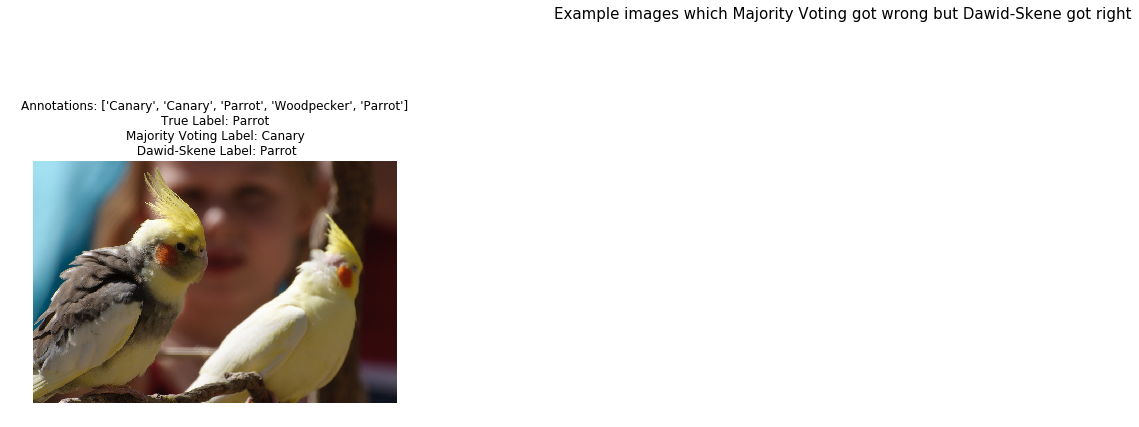

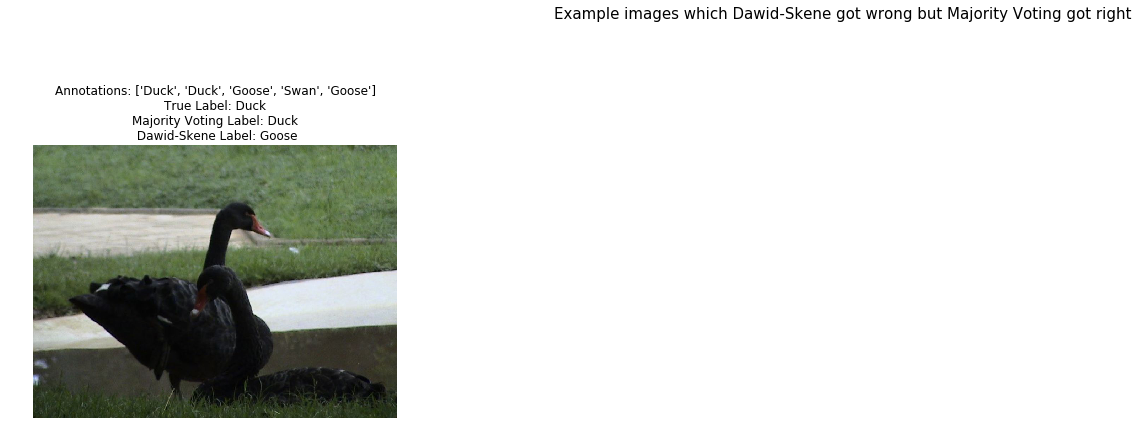

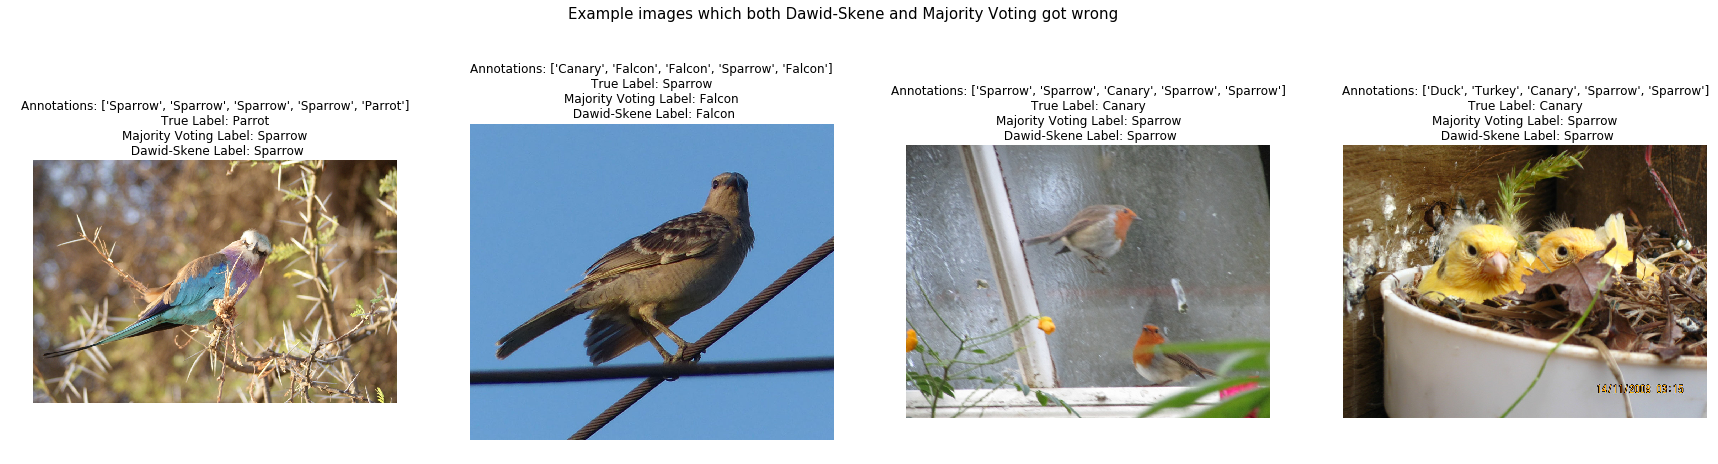

In [15]:
fig_title = "Example images which Majority Voting got wrong but Dawid-Skene got right"
visualize_images(list(images_ds_got_right_mv_got_wrong), dset_id_to_annotations_dict, 
                 img_uris, y_true_ds.values, y_pred_ds.values, y_pred_mv.values, fig_title)

fig_title = "Example images which Dawid-Skene got wrong but Majority Voting got right"
visualize_images(list(images_mv_got_right_ds_got_wrong), dset_id_to_annotations_dict, 
                 img_uris, y_true_ds.values, y_pred_ds.values, y_pred_mv.values, fig_title)

fig_title = "Example images which both Dawid-Skene and Majority Voting got wrong"
visualize_images(list(images_mv_got_wrong_ds_got_wrong), dset_id_to_annotations_dict, 
                 img_uris, y_true_ds.values, y_pred_ds.values, y_pred_mv.values, fig_title)